<a href="https://colab.research.google.com/github/DhawalaRajakaruna/ML-Practise/blob/main/NumberPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
od.download("https://www.kaggle.com/datasets/olafkrastovski/handwritten-digits-0-9?select=1")  # Replace with the actual dataset URL


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dhawalarajakaruna
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/olafkrastovski/handwritten-digits-0-9


100%|██████████| 66.7M/66.7M [00:04<00:00, 14.2MB/s]


In [5]:
dataset_path = "/content/handwritten-digits-0-9"  # Adjust if needed
base_dir = "/content/split_digits"

# Create train, val, test directories
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

for sub_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(sub_dir, exist_ok=True)
    for i in range(10):  # For digits 0-9
        os.makedirs(os.path.join(sub_dir, str(i)), exist_ok=True)


In [6]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for digit in range(10):
    digit_path = os.path.join(dataset_path, str(digit))
    images = os.listdir(digit_path)

    # Split into train, val, test
    train_files, temp_files = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

    # Move files to respective directories
    for img in train_files:
        shutil.copy(os.path.join(digit_path, img), os.path.join(train_dir, str(digit), img))
    for img in val_files:
        shutil.copy(os.path.join(digit_path, img), os.path.join(val_dir, str(digit), img))
    for img in test_files:
        shutil.copy(os.path.join(digit_path, img), os.path.join(test_dir, str(digit), img))


In [7]:
for sub_dir in [train_dir, val_dir, test_dir]:
    print(f"\n{sub_dir} data distribution:")
    for i in range(10):
        print(f"Class {i}: {len(os.listdir(os.path.join(sub_dir, str(i))))} images")




/content/split_digits/train data distribution:
Class 0: 1565 images
Class 1: 1568 images
Class 2: 1563 images
Class 3: 1541 images
Class 4: 1525 images
Class 5: 1488 images
Class 6: 1484 images
Class 7: 1481 images
Class 8: 1459 images
Class 9: 1411 images

/content/split_digits/val data distribution:
Class 0: 335 images
Class 1: 336 images
Class 2: 335 images
Class 3: 330 images
Class 4: 327 images
Class 5: 319 images
Class 6: 318 images
Class 7: 317 images
Class 8: 313 images
Class 9: 302 images

/content/split_digits/test data distribution:
Class 0: 336 images
Class 1: 337 images
Class 2: 335 images
Class 3: 331 images
Class 4: 327 images
Class 5: 319 images
Class 6: 319 images
Class 7: 318 images
Class 8: 313 images
Class 9: 303 images


Preprocessing and Augmentation

In [9]:
# Import required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image parameters
img_size = (64, 64)  # Resize all images to 64x64
batch_size = 32

# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixel values
    rotation_range=10,    # Rotate images slightly
    width_shift_range=0.1,# Shift images horizontally
    height_shift_range=0.1,# Shift images vertically
    shear_range=0.1,      # Apply shearing
    zoom_range=0.1,       # Apply zooming
    horizontal_flip=False,# No horizontal flipping (digits are upright)
)

# No augmentation for validation & test sets, only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load the dataset
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='sparse'
)


Found 15085 images belonging to 10 classes.
Found 3232 images belonging to 10 classes.
Found 3238 images belonging to 10 classes.


Model


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(10, activation='softmax')  # Output layer for 10 classes (0-9)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,626,442 (6.20 MB)

 Trainable params: 1,626,442 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Increase if needed
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


472/472 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.3119 - loss: 1.9124 - val_accuracy: 0.8391 - val_loss: 0.5394
Epoch 2/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.7057 - loss: 0.9189 - val_accuracy: 0.9251 - val_loss: 0.2886
Epoch 3/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.7755 - loss: 0.6833 - val_accuracy: 0.9394 - val_loss: 0.2204
Epoch 4/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step - accuracy: 0.8205 - loss: 0.5532 - val_accuracy: 0.9468 - val_loss: 0.1902
Epoch 5/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.8440 - loss: 0.5066 - val_accuracy: 0.9619 - val_loss: 0.1351
Epoch 6/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step - accuracy: 0.8566 - loss: 0.4380 - val_accuracy: 0.9657 - val_loss: 0.1214
Epoch 7/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - accuracy: 0.8767 - loss: 0.3860 - val_accuracy: 0.9663 - val_loss: 0.1275
Epoch 8/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.8829 - loss: 0.3586 - val_accurac

evaluate the model using test set

In [12]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9803 - loss: 0.0750
Test Accuracy: 97.37%


Save the model

In [13]:
model.save("handwritten_digit_model.h5")


In [14]:
from tensorflow.keras.models import load_model

# Load the trained model (ensure you specify the correct path)
model = load_model('/content/handwritten_digit_model.h5')


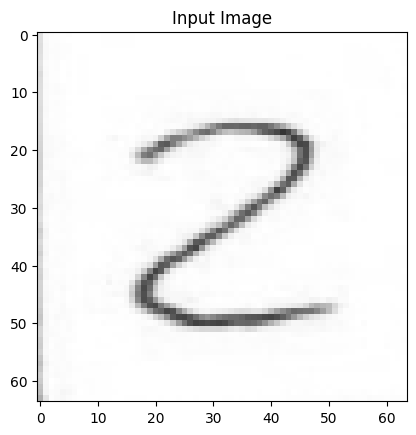

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicted digit: 2


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to load and preprocess the image
def preprocess_image(img_path):
    # Load the image using OpenCV (grayscale)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize to 64x64 (the size the model was trained on)
    img = cv2.resize(img, (64, 64))

    # Normalize the image to [0, 1] range
    img = img / 255.0

    # Convert to 3 channels by repeating the grayscale values
    img = np.stack([img] * 3, axis=-1)  # Now the shape will be (64, 64, 3)

    # Add batch dimension (1, 64, 64, 3)
    img = np.expand_dims(img, axis=0)

    return img

# Provide the image path (adjust as needed)
img_path = '/content/num.jpeg'

# Preprocess the image
processed_image = preprocess_image(img_path)

# Display the processed image (for verification)
plt.imshow(processed_image[0])  # processed_image is (1, 64, 64, 3), so we display processed_image[0]
plt.title("Input Image")
plt.show()

# Make a prediction using the trained model
prediction = model.predict(processed_image)

# Get the predicted digit
predicted_digit = np.argmax(prediction)

print(f"Predicted digit: {predicted_digit}")